<a href="https://colab.research.google.com/github/lucevito/image/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [8]:
def printPlotLoss(history, d):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.savefig("plotLoss" + str(d) + ".png")
    plt.show()
    plt.close()

def printPlotAccuracy(history, d):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    #plt.savefig("plotAccuracy" + str(d) + ".png")
    plt.show()
    plt.close()

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from imblearn.metrics import geometric_mean_score
import pandas as pd
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
def print_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision_negative = precision_score(y_true, y_pred, pos_label=0)
    recall_negative = recall_score(y_true, y_pred, pos_label=0)
    fscore_negative = f1_score(y_true, y_pred, pos_label=0)
    precision_positive = precision_score(y_true, y_pred, pos_label=1)
    recall_positive = recall_score(y_true, y_pred, pos_label=1)
    fscore_positive = f1_score(y_true, y_pred, pos_label=1)
    average_accuracy = (accuracy_score(y_true, y_pred) +
                        accuracy_score(y_true, y_pred, normalize=False)) / 2
    overall_accuracy = accuracy_score(y_true, y_pred)
    gmean = geometric_mean_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    print("True Negative (TN):", tn)
    print("False Positive (FP):", fp)
    print("False Negative (FN):", fn)
    print("True Positive (TP):", tp)
    print("Precision (Negative Class):", precision_negative)
    print("Recall (Negative Class):", recall_negative)
    print("F-score (Negative Class):", fscore_negative)
    print("Precision (Positive Class):", precision_positive)
    print("Recall (Positive Class):", recall_positive)
    print("F-score (Positive Class):", fscore_positive)
    print("Average Accuracy:", average_accuracy)
    print("Overall Accuracy:", overall_accuracy)
    print("G-Mean:", gmean)
    print("AUC (Area Under the Curve):", roc_auc)
    print("\n")

def save_csv(model_name, dataset_name, param, y_true, y_pred):
  file_name = 'risultati_modelli.xlsx'
  cm = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()
  precision_negative = precision_score(y_true, y_pred, pos_label=0)
  recall_negative = recall_score(y_true, y_pred, pos_label=0)
  fscore_negative = f1_score(y_true, y_pred, pos_label=0)
  precision_positive = precision_score(y_true, y_pred, pos_label=1)
  recall_positive = recall_score(y_true, y_pred, pos_label=1)
  fscore_positive = f1_score(y_true, y_pred, pos_label=1)
  average_accuracy = (accuracy_score(y_true, y_pred) +
                      accuracy_score(y_true, y_pred, normalize=False)) / 2
  overall_accuracy = accuracy_score(y_true, y_pred)
  gmean = geometric_mean_score(y_true, y_pred)
  roc_auc = roc_auc_score(y_true, y_pred)

  results = [
      {
          'Modello': model_name,
          'Dataset': dataset_name,
          'Parametri della configurazione': param,
          'True Negative': tn,
          'False Negative': fn,
          'False Positive': fp,
          'True Positive': tp,
          'Precision Negative': precision_negative,
          'Recall Negative': recall_negative,
          'Fscore Negative': fscore_negative,
          'Precision Positive': precision_positive,
          'Recall Positive': recall_positive,
          'Fscore Positive': fscore_positive,
          'Average Accuracy': average_accuracy,
          'Overall Accuracy': overall_accuracy,
          'GMean': gmean,
          'AUC': roc_auc,
      },
  ]

  if os.path.exists(file_name):
      existing_df = pd.read_excel(file_name)
      df = pd.concat([existing_df, pd.DataFrame(results)])
  else:
      df = pd.DataFrame(results)
  wb = Workbook()
  ws = wb.active
  for r in dataframe_to_rows(df, index=False, header=True):
      ws.append(r)
  wb.save(file_name)


In [10]:
from sklearn.preprocessing import MinMaxScaler
import glob
import numpy as np

def loaddataset(directory):
  images_files = glob.glob(directory + '/images' + '/*.npy')
  masks_files = glob.glob(directory + '/masks' + '/*.npy')
  x = np.array([np.load(file) for file in images_files])
  y = np.array([np.load(file) for file in masks_files])
  x = x.reshape(len(x) * len(x[0]) * len(x[0][0]), 10)
  y = y.reshape(len(y) * len(y[0]) * len(y[0][0]), 1)
  y = np.ravel(y)
  scaler=MinMaxScaler()
  x=scaler.fit_transform(x)
  return x,y

In [11]:
import tensorflow
from keras.layers import Input, Dense
from keras import optimizers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import callbacks
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model


def MLP_architecture(train_X):
    n_col = train_X.shape[1]
    input = Input(shape=(n_col,))

    hidden1 = Dense(128, activation='relu',
                    kernel_initializer='glorot_uniform',
                    name='l1')(input)
    hidden2= Dense(64, activation='relu',
                    kernel_initializer='glorot_uniform',
                    name='l2')(hidden1)

    hidden3 = Dense(32, activation='relu',
               kernel_initializer='glorot_uniform',
               name='l3')(hidden2)
    output=Dense(2,activation='softmax')(hidden3)
    model=Model(inputs=input, outputs=output)
    model.summary()
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.0001)) #change this
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 l1 (Dense)                  (None, 128)               1408      
                                                                 
 l2 (Dense)                  (None, 64)                8256      
                                                                 
 l3 (Dense)                  (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 11,810
Trainable params: 11,810
Non-trainable params: 0
_________________________________________________________________


Epoch 1/150
16743/16743 - 69s - loss: 0.1536 - accuracy: 0.9648 - val_loss: 0.1519 - val_accuracy: 0.9649 - 69s/epoch - 4ms/step
Epoch 2/150
16743/16743 - 61s - loss: 0.1520 - accuracy: 0.9649 - val_loss: 0.1512 - val_accuracy: 0.9649 - 61s/epoch - 4ms/step
Epoch 3/150
16743/16743 - 62s - loss: 0.1512 - accuracy: 0.9649 - val_loss: 0.1513 - val_accuracy: 0.9649 - 62s/epoch - 4ms/step
Epoch 4/150
16743/16743 - 61s - loss: 0.1510 - accuracy: 0.9649 - val_loss: 0.1520 - val_accuracy: 0.9649 - 61s/epoch - 4ms/step
Epoch 5/150
16743/16743 - 73s - loss: 0.1507 - accuracy: 0.9649 - val_loss: 0.1505 - val_accuracy: 0.9649 - 73s/epoch - 4ms/step
Epoch 6/150
16743/16743 - 62s - loss: 0.1505 - accuracy: 0.9649 - val_loss: 0.1511 - val_accuracy: 0.9649 - 62s/epoch - 4ms/step
Epoch 7/150
16743/16743 - 63s - loss: 0.1502 - accuracy: 0.9649 - val_loss: 0.1503 - val_accuracy: 0.9649 - 63s/epoch - 4ms/step
Epoch 8/150
16743/16743 - 63s - loss: 0.1501 - accuracy: 0.9649 - val_loss: 0.1501 - val_accuracy

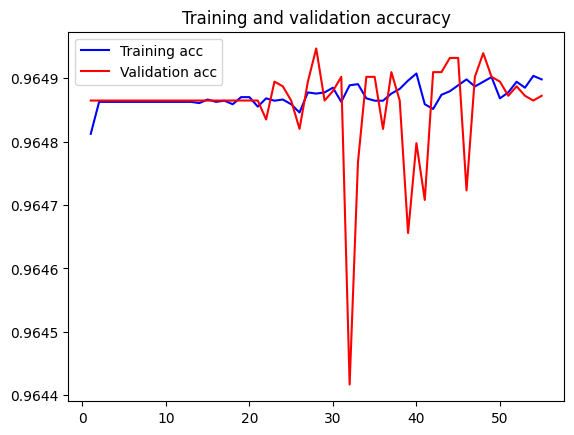

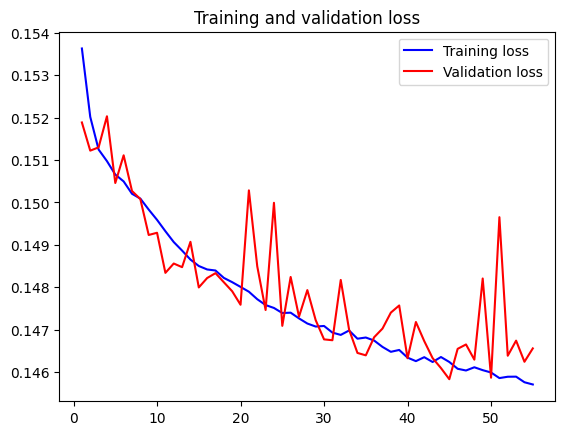

In [12]:
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.utils import np_utils
import matplotlib.pyplot as plt

train_path = 'Immagini_satellitari/Train'
test_path = 'Immagini_satellitari/Test/'
model_name = "mlp.h"
param = 'mlp'

trainX,trainY = loaddataset(train_path)
testX,testY = loaddataset(test_path)

model=MLP_architecture(trainX)
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True), ]

XTraining, XValidation, YTraining, YValidation = train_test_split(trainX, trainY, stratify=trainY, test_size=0.2)
YTraining = np_utils.to_categorical(YTraining, 2)
YValidation = np_utils.to_categorical(YValidation, 2)
#ho incremento dall'originale 30 epoch a 150
history = model.fit(XTraining, YTraining, batch_size=32, epochs=150, verbose=2, callbacks=callbacks_list
              , shuffle= True , validation_data=(XValidation, YValidation))

printPlotAccuracy(history, 'MLP')
printPlotLoss(history, 'MLP')
model.save(model_name)


In [15]:
from sklearn.metrics import classification_report,confusion_matrix
import os

y_predicted = model.predict(testX, verbose=0, use_multiprocessing=True, workers=12)
y_predicted = np.argmax(y_predicted, axis=1)
print("CLassification test: ")
print(classification_report(testY,y_predicted))
print("TEST : ")
print_metrics(testY,y_predicted)
save_csv(model_name, 'Test Set', param, testY, y_predicted)


print("TRAIN : ")
y_predicted = model.predict(trainX, verbose=0, use_multiprocessing=True, workers=12)
y_predicted = np.argmax(y_predicted, axis=1)
print("CLassification train: ")
print(classification_report(trainY, y_predicted))
print_metrics(trainY,y_predicted)
save_csv(model_name, 'Train Set', param, trainY, y_predicted)


CLassification test: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    162100
           1       0.00      0.00      0.00      2764

    accuracy                           0.98    164864
   macro avg       0.49      0.50      0.50    164864
weighted avg       0.97      0.98      0.97    164864

TEST : 
True Negative (TN): 162098
False Positive (FP): 2
False Negative (FN): 2764
True Positive (TP): 0
Precision (Negative Class): 0.9832344627627956
Recall (Negative Class): 0.9999876619370759
F-score (Negative Class): 0.9915403013194195
Precision (Positive Class): 0.0
Recall (Positive Class): 0.0
F-score (Positive Class): 0.0
Average Accuracy: 81049.49161126747
Overall Accuracy: 0.9832225349378882
G-Mean: 0.0
AUC (Area Under the Curve): 0.49999383096853794


TRAIN : 
CLassification train: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    646165
           1       0.66      0.00      0.0